In [1]:
from src.ds import UCMerced, HQLQ
from src.util import random_split_ratio, psnr
from src.srresnet import SRResNet
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import random
import os
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr, structural_similarity as ssim 
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

## Training progress

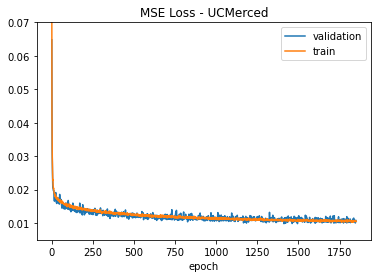

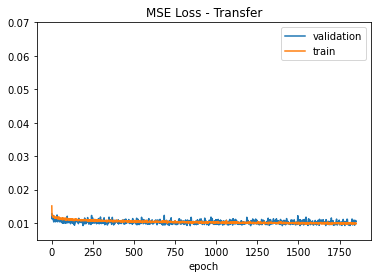

In [32]:
log_landuse=pd.read_csv('log_landuse.csv')
plt.title('MSE Loss - UCMerced')
plt.plot(log_landuse['val_loss'].dropna(), label='validation')
plt.plot(log_landuse['train_loss'].dropna(),label='train')
plt.xlabel('epoch')
plt.legend()
plt.savefig('images/loss_landuse.png')
plt.ylim(0.005,0.07)
plt.show()


log_transfer=pd.read_csv('log_transfer.csv')
plt.title('MSE Loss - Transfer')
plt.plot(log_transfer['val_loss'].dropna(), label='validation')
plt.plot(log_transfer['train_loss'].dropna(),label='train')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.005,0.07)
plt.savefig('images/loss_transfer.png')
plt.show()



## Test

In [3]:
#fix random seeds, such that train/lest split etc is reprodcible and constant between runs and notebooks

seed=31415
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
dataset=UCMerced('data')

##########These parameters should be the same in both notebooks, idealy be saved to hdf5 or pickle..########
#image augmentation transformations for train, validation and test
augments = [
    [
        transforms.RandomCrop((96, 96)),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
    ],
    [],
    [],
]
scaling_factor = 4
valratio = 0.1
testratio = 0.1

# Model parameters -- taken from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 16  # number of residual blocks

##################

trainds, valds, testds = (
    HQLQ(ds, aug, scalingfactor=scaling_factor,hqcropsize=256) #don't crop in test
    for ds, aug in zip(random_split_ratio(dataset, valratio, testratio), augments)
)

test_loader = DataLoader(testds, batch_size=1)  

In [33]:
def plot_result(weightpath):
    with torch.no_grad():
        weightname=os.path.splitext(os.path.split(weightpath)[-1])[0]
        print(weightname)

        #create model and load weights
        model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                          n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
        model.load_state_dict(torch.load(weightpath))
        model=model.eval()


        #transformations
        #undoing the normalisation
        undo_hq=transforms.Compose([transforms.Lambda(lambda x: (x+1)/2),transforms.ToPILImage()])
        undo_lq=transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1./0.229, 1./0.224, 1./0.225]),transforms.ToPILImage(),transforms.Resize(256,Image.NEAREST)])
        #bicubic upscaling
        upscale=transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1./0.229, 1./0.224, 1./0.225]),transforms.ToPILImage(),transforms.Resize(256,Image.BICUBIC)])

        df=pd.DataFrame() 
        for i,(lq,hq) in  enumerate(test_loader):
            sr = [undo_hq(x) for x in model.forward(lq)]
            gt = [undo_hq(x) for x in hq]
            upscaled = [upscale(x) for x in lq]
            lq = [undo_lq(x) for x in lq]

            for icsr,icgt,icupscaled,iclq in zip(sr,gt,upscaled,lq):
                csr,cgt,cupscaled,clq = (np.array(x) for x in (icsr,icgt,icupscaled,iclq))
                #stats
                df = df.append({
                    'psnr_sr':psnr(cgt,csr),
                    'psnr_upscale':psnr(cgt,cupscaled),
                    'mse_sr':mse(cgt,csr),
                    'mse_upscale':mse(cgt,cupscaled),
                    'ssim_sr':ssim(cgt,csr,multichannel=True),
                    'ssim_upscale':ssim(cgt,cupscaled,multichannel=True)
                },ignore_index=True)

                if i<10: #plot some images
                    f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2)
                    ax1.imshow(clq)
                    ax1.set_axis_off()
                    ax1.set_title('Low Resolution')
                    ax2.imshow(cupscaled)
                    ax2.set_axis_off()
                    ax2.set_title(f'Bicubic Upscaling')
                    ax3.imshow(csr)
                    ax3.set_axis_off()
                    ax3.set_title(f'SRResNet')
                    ax4.imshow(cgt)
                    ax4.set_axis_off()
                    ax4.set_title('Ground Truth')
                    (Path("images")/weightname).mkdir(parents=True, exist_ok=True)
                    plt.savefig(f'images/{weightname}/img{i}.png')
                    plt.show()

        f,axs=plt.subplots(3,figsize=(10,15))
        for k,ax in zip(['psnr','mse','ssim'],axs):
            ax.hist(df[f'{k}_sr'],alpha=0.5,label='SR',bins=20)
            ax.hist(df[f'{k}_upscale'],alpha=0.5,label='Bicubic Upscaling',bins=20)
            ax.legend()
            ax.set_title(f'{k} distribution')
            ax.set_xlabel(k)
            ax.set_ylabel('frequency in test')
        f.tight_layout()
        plt.savefig(f'images/hist_{weightname}.png')
        plt.show()
        return df

## Results for training on UCMerced landuse

landuse


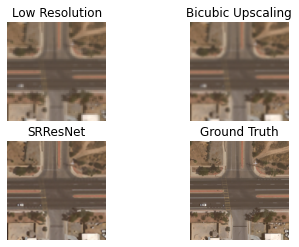

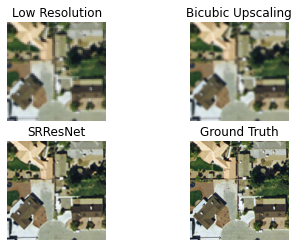

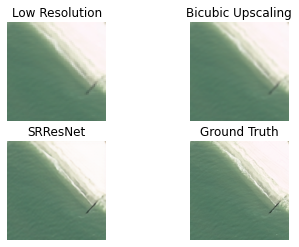

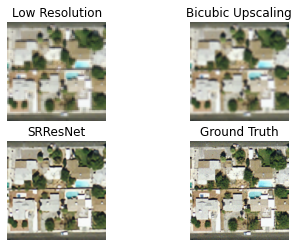

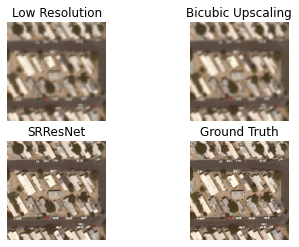

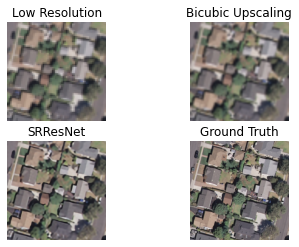

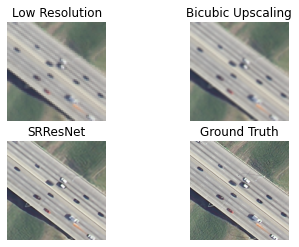

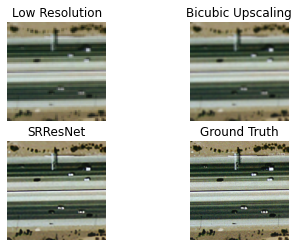

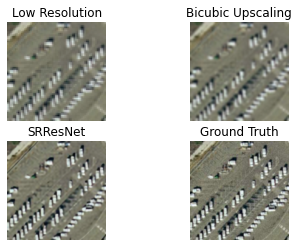

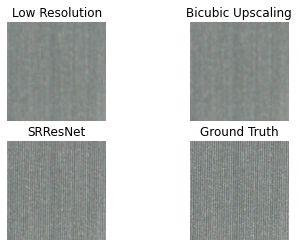

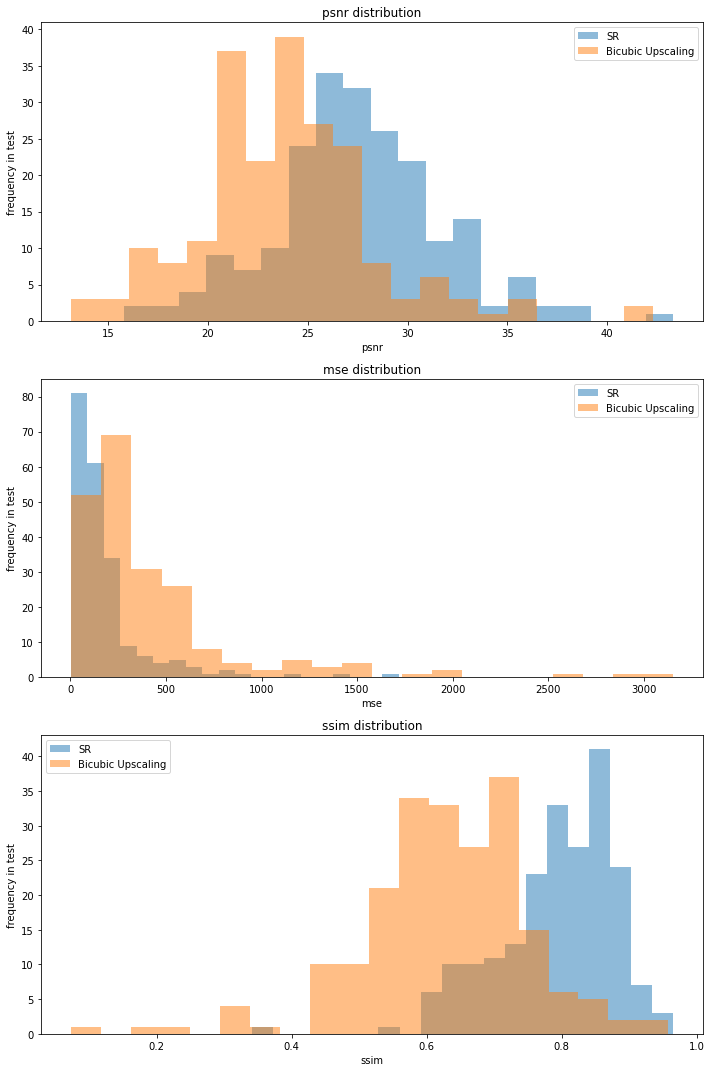

means
 mse_sr          181.889168
mse_upscale     422.789053
psnr_sr          27.561644
psnr_upscale     23.819681
ssim_sr           0.792032
ssim_upscale      0.628878
dtype: float64 

stds
 mse_sr          223.613875
mse_upscale     466.300894
psnr_sr           4.234952
psnr_upscale      4.427046
ssim_sr           0.087212
ssim_upscale      0.124804
dtype: float64 



In [34]:
df_landuse = plot_result('weights/landuse.zip')

print('means\n',df_landuse.mean(),'\n')
print('stds\n',df_landuse.std(),'\n')

df_landuse.to_csv('test_landuse.csv')

## Results for sgrvinod's weights (trained on MSCOCO)

sgrvinod


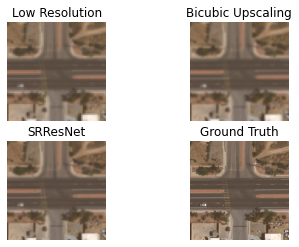

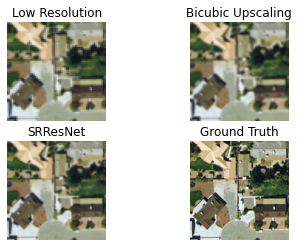

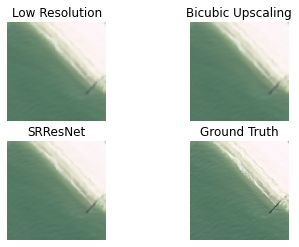

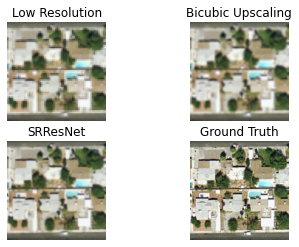

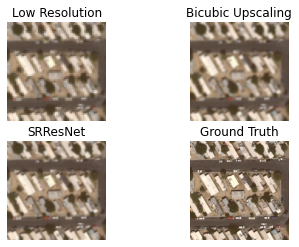

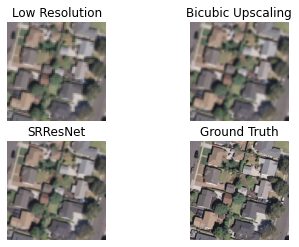

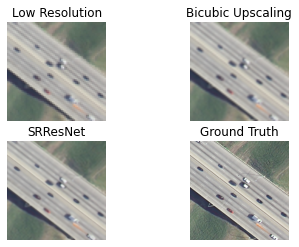

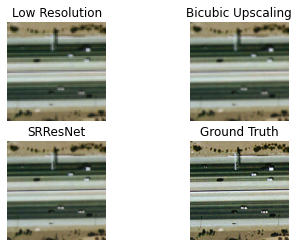

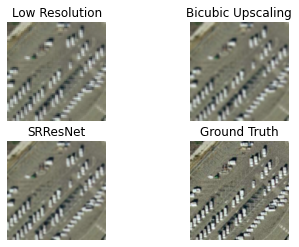

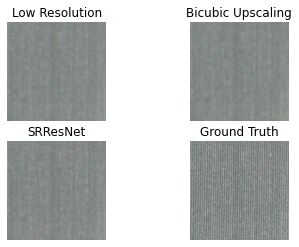

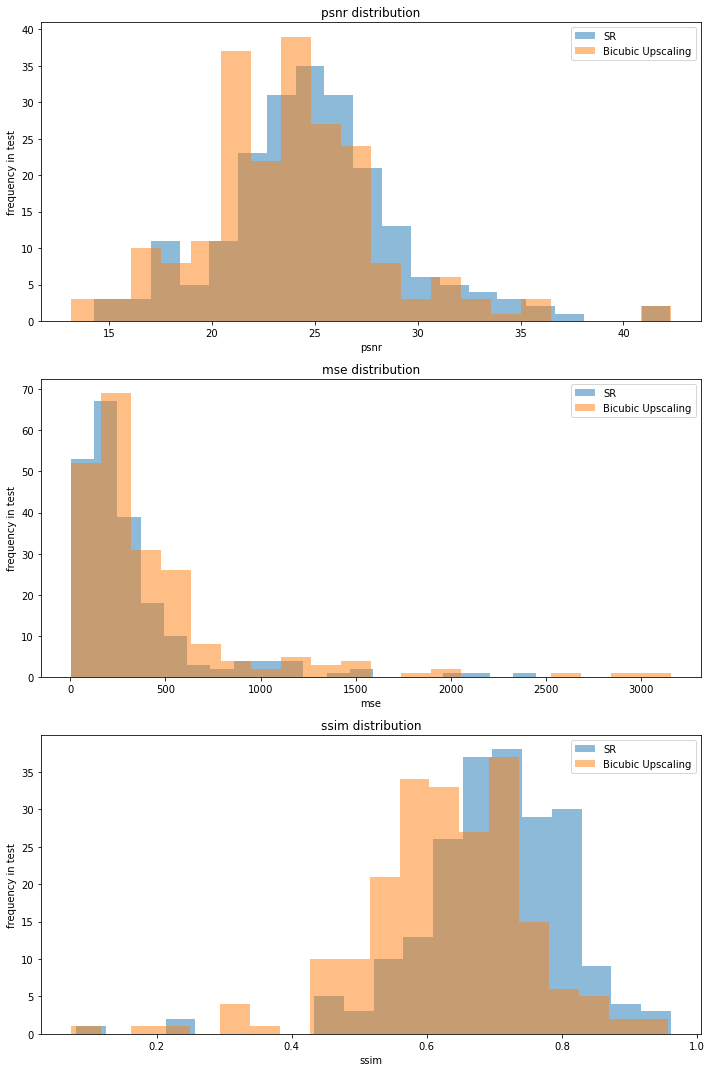

means
 mse_sr          323.810087
mse_upscale     422.789053
psnr_sr          24.981538
psnr_upscale     23.819681
ssim_sr           0.697668
ssim_upscale      0.628878
dtype: float64 

stds
 mse_sr          362.253197
mse_upscale     466.300894
psnr_sr           4.358622
psnr_upscale      4.427046
ssim_sr           0.115508
ssim_upscale      0.124804
dtype: float64 



In [35]:
df_sgrvinod = plot_result('weights/sgrvinod.zip')

print('means\n',df_sgrvinod.mean(),'\n')
print('stds\n',df_sgrvinod.std(),'\n')

df_sgrvinod.to_csv('test_sgrvinod.csv')

## Results for using sgrvinod's weights as starting point and training on the UCMerced Dataset


transfer


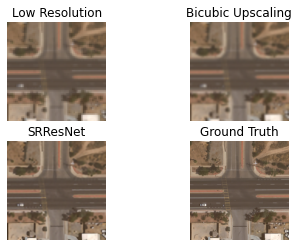

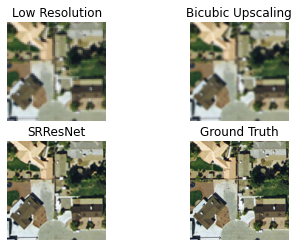

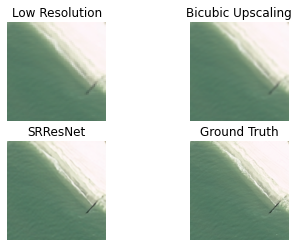

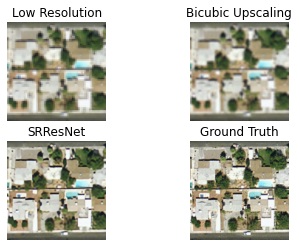

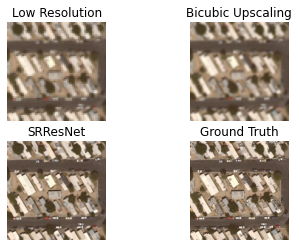

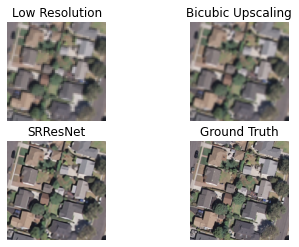

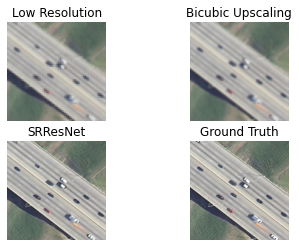

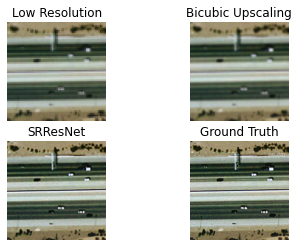

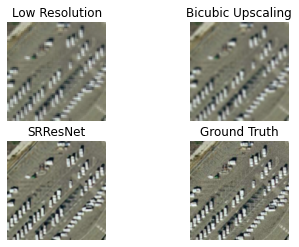

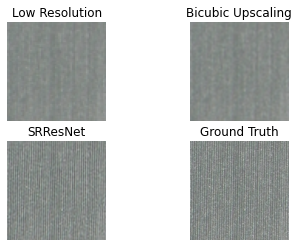

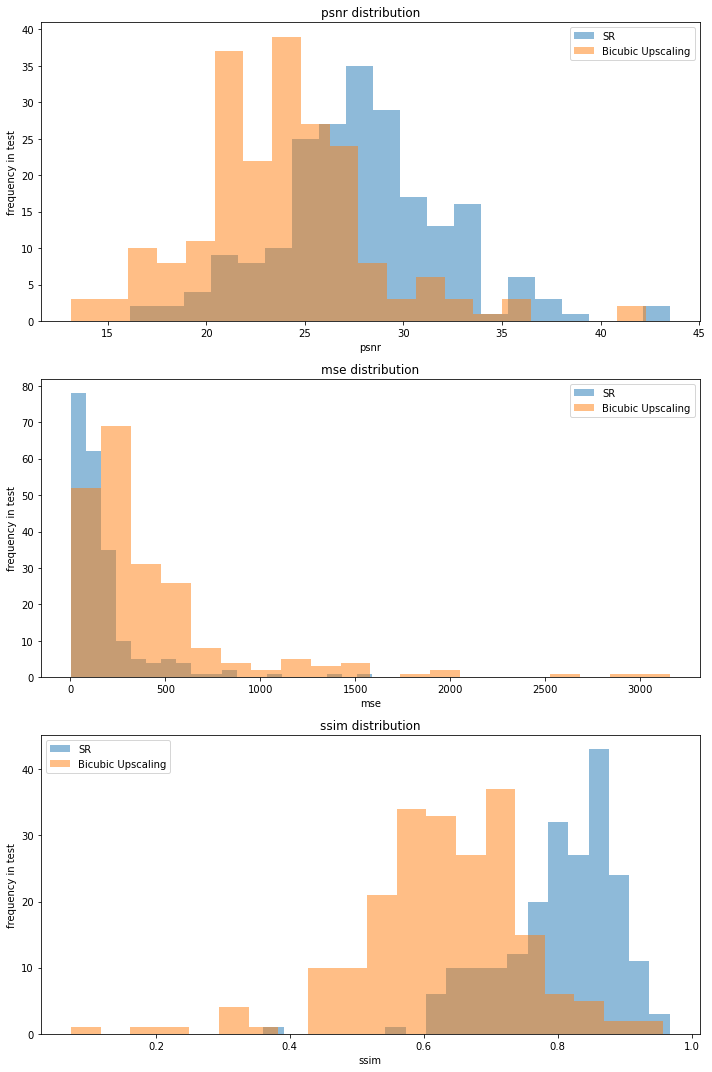

means
 mse_sr          170.132009
mse_upscale     422.789053
psnr_sr          27.893695
psnr_upscale     23.819681
ssim_sr           0.803297
ssim_upscale      0.628878
dtype: float64 

stds
 mse_sr          208.711023
mse_upscale     466.300894
psnr_sr           4.331213
psnr_upscale      4.427046
ssim_sr           0.086096
ssim_upscale      0.124804
dtype: float64 



In [36]:
df_transfer = plot_result('weights/transfer.zip')

print('means\n',df_transfer.mean(),'\n')
print('stds\n',df_transfer.std(),'\n')

df_transfer.to_csv('test_transfer.csv')

## upscale further than used for training..

In [ ]:
weightpath='weights/transfer.zip'
weightname=os.path.splitext(os.path.split(weightpath)[-1])[0]
#create model and load weights
model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                  n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
model.load_state_dict(torch.load(weightpath))
model=model.eval()

do_lq= transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
undo_hq=transforms.Compose([transforms.Lambda(lambda x: (x+1)/2),transforms.ToPILImage()])
upscale=transforms.Compose([transforms.Resize(1024,Image.BICUBIC)])
    #upscale=transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1./0.229, 1./0.224, 1./0.225]),transforms.ToPILImage(),transforms.Resize(96,Image.BICUBIC)])

df=pd.DataFrame() 
for i,lq in  enumerate(dataset):
    lq_scaled = do_lq(lq).unsqueeze(0)
    sr = undo_hq(model.forward(lq_scaled).squeeze(0))
    upscaled = upscale(lq)
    display(sr)
    disply(upscaled)
    break